<a href="https://colab.research.google.com/github/salvaderron/Artificial-Neural-Network_and_Deep-Learning/blob/main/ANN_%26_DL_Lab_10_(GNN_link_prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 050, Loss: 0.4880
Epoch 100, Loss: 0.4003
Epoch 150, Loss: 0.3733
Epoch 200, Loss: 0.3359

Test AUC: 0.8872


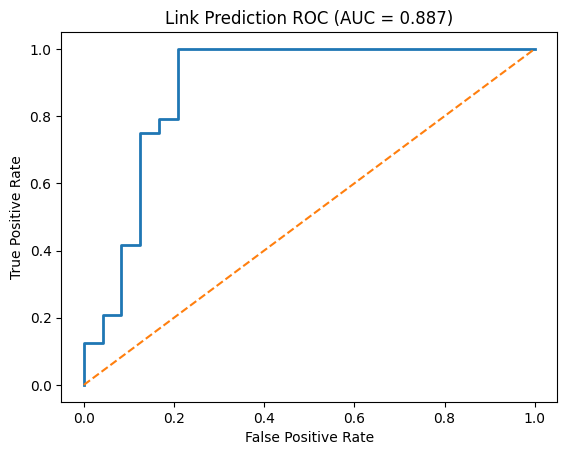

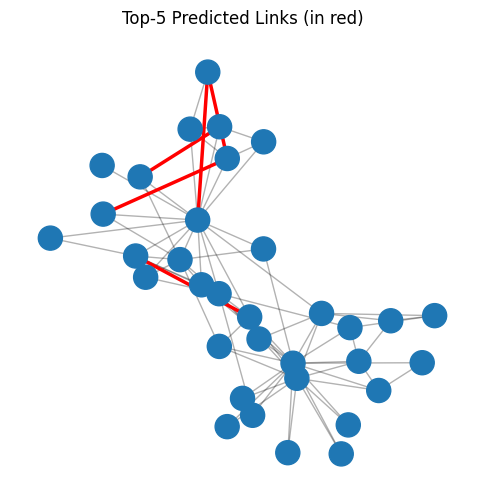

In [1]:
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# 1. Load graph and build normalized adjacency
G = nx.karate_club_graph()
N = G.number_of_nodes()
A = nx.to_numpy_array(G)
A_hat = A + np.eye(N)
D_inv_sqrt = np.diag(1.0 / np.sqrt(A_hat.sum(1)))
A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt    # (N, N)

# 2. Prepare positive & negative edge samples
all_pos = np.array(list(G.edges()), dtype=np.int32)
# Split positives into train/test
pos_train, pos_test = train_test_split(all_pos, test_size=0.3, random_state=42)

# Sample negative edges (u,v) where no edge exists
neg_candidates = np.array(
    [(i, j) for i in range(N) for j in range(i+1, N) if not G.has_edge(i, j)],
    dtype=np.int32
)
neg = neg_candidates[np.random.choice(len(neg_candidates), size=len(all_pos), replace=False)]
neg_train, neg_test = train_test_split(neg, test_size=0.3, random_state=42)

# Stack train/test sets and labels
train_edges = np.vstack([pos_train, neg_train])
train_labels = np.hstack([np.ones(len(pos_train)), np.zeros(len(neg_train))])
test_edges  = np.vstack([pos_test, neg_test])
test_labels = np.hstack([np.ones(len(pos_test)), np.zeros(len(neg_test))])

# 3. Define GCN embedding model
class GCNLayer(layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = layers.Activation(activation) if activation else None

    def build(self, input_shape):
        F_in = input_shape[-1]
        self.w = self.add_weight(shape=(F_in, self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        # bake normalized adjacency
        self.A_norm = tf.constant(A_norm, dtype=tf.float32)
        super().build(input_shape)

    def call(self, X):
        x = tf.matmul(self.A_norm, X)   # (N, F_in)
        x = tf.matmul(x, self.w)        # (N, units)
        if self.activation:
            x = self.activation(x)
        return x                        # (N, units)

# Node features = identity (one-hot)
X_feat = np.eye(N, dtype=np.float32)  # (N, N)

# Build the embedding model
X_in = layers.Input(shape=(N,), name="X_row")  # each row of identity
# But we'll actually feed the full identity matrix as batch of N samples
X_full = layers.Lambda(lambda rows: tf.stack([rows], axis=0))(X_in)
# Actually simpler: we can input the full matrix directly:
# inputs = Input(shape=(N,N), name="X"); skip the Lambda. We'll feed X_feat[np.newaxis,...]

# Let's do that:
inputs = layers.Input(shape=(N, N), name="X")
h = GCNLayer(16, activation="relu")(inputs)    # (1, N, 16) if batched, or (N,16)
h = layers.Dropout(0.5)(h)
embeddings = GCNLayer(8, activation=None)(h)   # final embedding dim = 8

model = Model(inputs=inputs, outputs=embeddings)
optimizer = tf.keras.optimizers.Adam(1e-2)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# 4. Training loop
@tf.function
def train_step(edge_idx, labels):
    with tf.GradientTape() as tape:
        H = model(X_feat[np.newaxis, ...], training=True)[0]  # (N, emb_dim)
        # gather pairs
        hi = tf.gather(H, edge_idx[:,0])  # (batch, emb_dim)
        hj = tf.gather(H, edge_idx[:,1])
        # score = sigmoid(dot(hi, hj))
        scores = tf.reduce_sum(hi * hj, axis=1)
        preds = tf.sigmoid(scores)
        loss = bce(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

# full-batch training
edge_idx_train = tf.constant(train_edges)
labels_train   = tf.constant(train_labels, dtype=tf.float32)

for epoch in range(1, 201):
    loss = train_step(edge_idx_train, labels_train)
    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")

# 5. Evaluation on test set
H_final = model(X_feat[np.newaxis, ...], training=False)[0].numpy()  # (N, emb_dim)
hi_test = H_final[test_edges[:,0]]
hj_test = H_final[test_edges[:,1]]
scores_test = np.sum(hi_test * hj_test, axis=1)
probs_test  = 1 / (1 + np.exp(-scores_test))
auc = roc_auc_score(test_labels, probs_test)
print(f"\nTest AUC: {auc:.4f}")

# 6. Visualization

# 6a. ROC curve
fpr, tpr, _ = roc_curve(test_labels, probs_test)
plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Link Prediction ROC (AUC = {auc:.3f})")
plt.show()

# 6b. Graph with top-5 new predicted links (excluding known edges)
# rank non-edge pairs by predicted prob
non_edges = neg  # previously sampled negatives
neg_hi = H_final[non_edges[:,0]]
neg_hj = H_final[non_edges[:,1]]
neg_scores = np.sum(neg_hi * neg_hj, axis=1)
top5_idx = np.argsort(-neg_scores)[:5]
pred_edges = [tuple(edge) for edge in non_edges[top5_idx]]

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(6,6))
nx.draw_networkx_nodes(G, pos, node_size=300, cmap="tab20",
                       node_color=[0]*N)  # all same color
nx.draw_networkx_edges(G, pos, alpha=0.3)
# highlight predicted new links
nx.draw_networkx_edges(G, pos, edgelist=pred_edges, width=2.5, edge_color="red")
plt.title("Top-5 Predicted Links (in red)")
plt.axis("off")
plt.show()